# Цели и задачи исследования

Нам предоставлены данные сервиса аренды самокатов GoFast.  
Наша задача проанализировать имеющиеся данные и проверить несколько гипотез, которые помогут бизнесу вырасти.   

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:    
* без подписки    
    * абонентская плата отсутствует;    
    * стоимость одной минуты поездки — 8 рублей;    
    * стоимость старта (начала поездки) — 50 рублей;    
* с подпиской Ultra    
    * абонентская плата — 199 рублей в месяц;    
    * стоимость одной минуты поездки — 6 рублей;    
    * стоимость старта — бесплатно.  

1. Первый этап - исследование данных.  
    1) При необходимости исправим аномалии (пропуски, дубликаты).  
    2) Опишем и визуализируем следующую информацию о поездках:  
        1 частота встречаемости городов;  
        2 соотношение пользователей с подпиской и без подписки;  
        3 возраст пользователей;  
        4 расстояние, которое пользователь преодолел за одну поездку;  
        5 продолжительность поездок;  
        6 информацию о расстоянии и времени поездок для пользователей с подпиской/без подиски;  
        7 по каждому пользователю вывести суммарное расстояние, количество поездок, суммарное время для каждого пользователя за каждый месяц и суммарную выручку, которую принес каждый пользователь.
        
2. Проверим гипотезы, которые должны помочь принять решение об увеличение числа клиентов с подпиской:  
    1) Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.     
    2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?   
    3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.     
3. Сформулируем общий вывод.
 

In [23]:
# импортируем нужные библиотеки
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math

In [24]:
class color: #классы для комфортного вывода текста
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


## Шаг 1. Загрузка данных

Выгрузим датасеты и ознакомимся с информацией по ним.

##### Данные о пользователях

In [25]:
#первая таблица users_go
users = pd.read_csv('users_go.csv')
print(color.BOLD + 'Пример данных' + color.END) # жирный шрифт, чтобы можно было комфортно разлечить блоки
display(users.sample(5))
print(color.BOLD + '\nОбщая информация о данных\n' + color.END)
users.info()
print(color.BOLD + '\nКоличество дубликатов' + color.END)
users.duplicated().sum()

Пример данных


,user_id,name,age,city,subscription_type
1248,1249,Амалия,28,Тюмень,free
1516,1517,Давид,25,Тюмень,free
866,867,Леонид,24,Ростов-на-Дону,free
681,682,Евгения,23,Сочи,ultra
996,997,Святогор,23,Сочи,free



Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

Количество дубликатов


31

В данной таблице мы видим следующие данные:  

_user_id_	уникальный идентификатор пользователя  
_name_	имя пользователя  
_age_	возраст  
_city_	город  
_subscription_type_	тип подписки (free, ultra)  

Данных о пользователях не много, с ними будет комфортно работать.  
Пропусков нет.  
В датасете 31 полный дубликат, что некорректно как минимум потому, что _user_id_ должен содержать Уникальный идентификатор.  
Скорее всего, какая-то ошибка выгрузки.  
Доля дубликатов меньше 2%, можем спокойно их удалить.  

In [52]:
users = users.drop_duplicates().reset_index(drop=True) 
#удаляем полные дубликаты
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


##### Данные о поездках

In [27]:
#таблица rides_go
rides = pd.read_csv('rides_go.csv')
print(color.BOLD + 'Пример данных' + color.END) # жирный шрифт, чтобы можно было комфортно разлечить блоки
display(rides.sample(5))
print(color.BOLD + '\nОбщая информация о данных\n' + color.END)
rides.info()
print(color.BOLD + '\nКоличество дубликатов' + color.END)
rides.duplicated().sum()

Пример данных


,user_id,distance,duration,date
4104,442,4470.269288,26.158297,2021-11-14
5984,640,2883.122029,13.207805,2021-05-14
13124,1184,2107.073749,11.020211,2021-10-09
14369,1270,1896.799919,18.754461,2021-03-08
5107,549,3393.540358,21.510220,2021-06-03



Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

Количество дубликатов


0

Датасет содержит информацию о поездках:  
_user_id_	уникальный идентификатор пользователя  
_distance_	расстояние, которое пользователь проехал в текущей сессии (в метрах)  
_duration_	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
_date_	дата совершения поездки  

Пропусков нет, дубликатов нет.

##### Данные о поподписках

In [28]:
sub = pd.read_csv('subscriptions_go.csv')
print(color.BOLD + 'Таблица' + color.END)
sub

Таблица


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Информация о видах подписок:  
_subscription_type_	тип подписки  
_minute_price_	стоимость одной минуты поездки по данной подписке  
_start_ride_price_	стоимость начала поездки  
_subscription_fee_	стоимость ежемесячного платежа  


## Шаг 2. Предобработка данных

Пропуски и полные явные дубликаты мы уже проверили выше.  
Стоит еще проверить столбец с названием города в таблице о пользователях на неявные дубликаты.

In [29]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Отлично, здесь тоже всё в порядке.

##### Проведем преобразования столбцов

Столбец с врменем пездки в минутах округлим вверх и приведем к целочисленному типу данных, т.к. стоимость поздки считается за целые минуты

In [53]:
rides['duration'] = np.ceil(rides['duration']).astype(int)

В колонке с датой в таблице о поездках тип данных object, приведем его к правильному типу date. 

In [54]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

In [55]:
rides.sample(5) # проверим проведенные изменения

,user_id,distance,duration,date,month
2397,255,3157.768964,24,2021-05-05,5
8125,820,3856.985889,22,2021-03-29,3
13580,1216,3060.445529,26,2021-02-16,2
978,104,2846.295437,19,2021-06-28,6
11934,1097,3287.105906,23,2021-02-03,2


##### Добавим столбец с месяцем

На этапе исследования нам понадобится столбец с номером месяца.  
Прежде, чем его добавить, посмотрим, за какие годы представлены данные, чтобы не получилось, что у нас не окажутся разные годы в одних и тех же месяцах.

In [56]:
rides['date'].dt.year.unique()

array([2021])

Год всего один, можем добавить столбец с месяцами.

In [57]:
rides['month'] = rides['date'].dt.month
sorted(rides['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Мы узнали, что информация о поездках у нас есть за все месяцы 2021г.

**Вывод**

Мы ознакомились с данными и провели небольшую предобработку:  
 1. Мы имеем информацию о 1534 пользователях сервиса GoFast  
 2. Информация собрана по 8 городам (Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар,
       Пятигорск, Екатеринбург, Сочи)
 3. Данные представлены за полный 2021г  
 4. В данных нет пропусков  
 5. Было небольшое количесто (меньше 2%) дубликатов в таблице о пользователях, мы их удалили 
 6. Столбец с врменем пездки в минутах округлили вверх и привели к целочисленному типу данных
 7. Изменили тип данных столбца _date_ таблицы _rides_ на верный (date) и удобный для работы  
 8. Добавили стобец с Месяцем, извлеченным из даты в таблице о поездках.

## Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

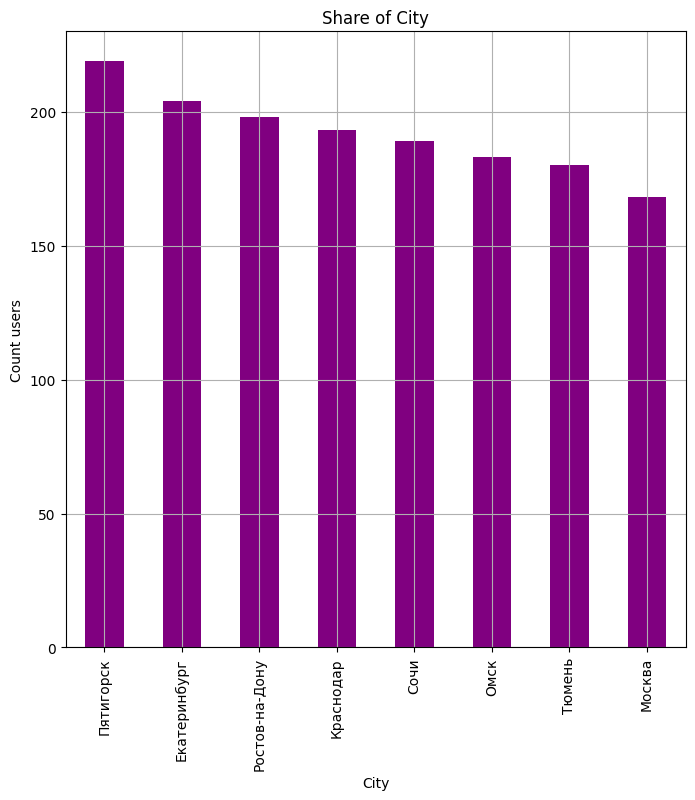

In [58]:
#на столбчатой диаграмме посмотрим на количество пользователей в городах
users['city'].value_counts(ascending=False).plot(kind='bar', figsize=(8,8),
 title='Share of City', color = 'purple')
plt.xlabel('City')
plt.ylabel('Count users')
plt.grid(True)
plt.show()

Больше всего пользователей из Пятигорска, меньше всего из Москвы, разница около 100человек.

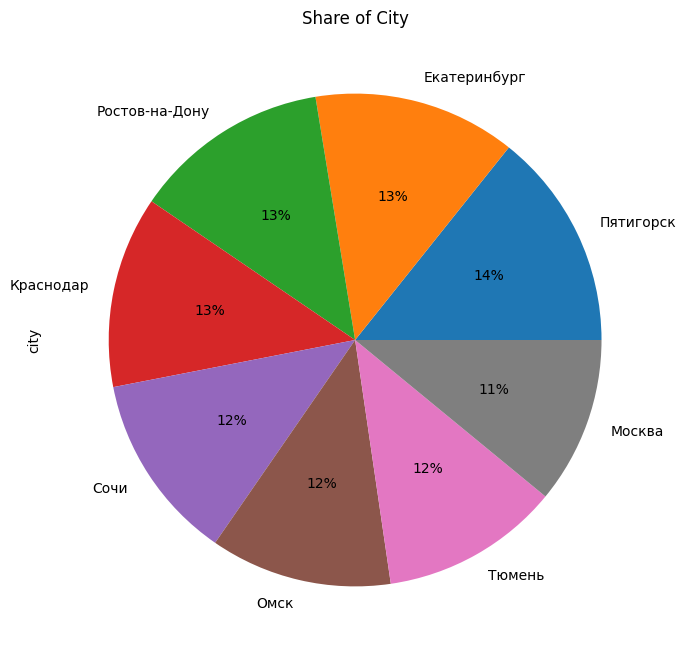

In [59]:
#посмотрим в долях
users['city'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.0f%%',
 title='Share of City')
plt.show()

Большой разницы в долях нет.  
Какой-то зависимости тоже не выявлено.  
Можно было бы предположить, что на количество пользователей будет влиять климат и количество теплых месяцев в году, однако, такой зависимости не видно.  
Возможно, это скорее связано с не самой большой выборкой (около 1,5тыс пользователей) и при этом 8 городов.  
Возможно, влияет наличие и количество конкурентов, но таких данных у нас нет.

##### Cоотношение пользователей с подпиской и без подписки

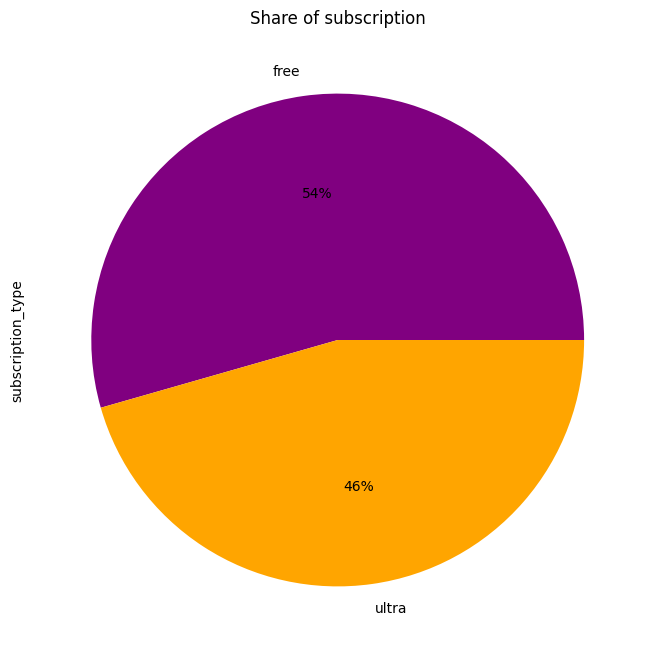

In [60]:
users['subscription_type'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.0f%%', colors=('purple','orange'),
 title='Share of subscription')
plt.show()

Пользователей с подписой всего на 8p.pt или 15% меньше.  
Давольно высокая доля пользователей пользуется подпиской(46%)

##### Возраст пользователей

Количественная информация


count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Распределение по возрасту



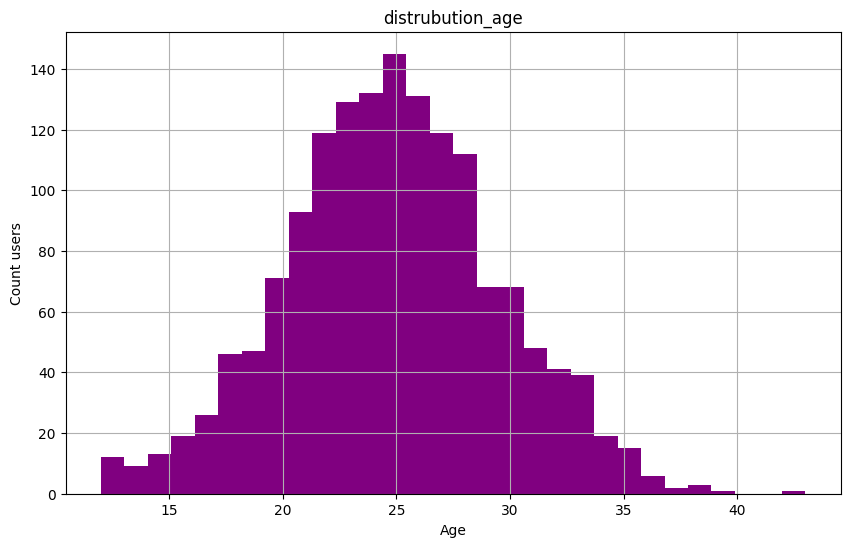

In [61]:
print(color.BOLD + 'Количественная информация' + color.END) # жирный шрифт, чтобы можно было комфортно разлечить блоки
display(users['age'].describe())
print(color.BOLD + 'Распределение по возрасту\n' + color.END)
users['age'].hist(bins = 30, color='purple', figsize=(10,6))
plt.title('distrubution_age')
plt.xlabel('Age')
plt.ylabel('Count users')
plt.grid(True)
plt.show()

Возраст пользователей распределен от 12 до 43 лет.  
Основная часть - от 22 до 27 лет.  
При этом, старше 34 пользователей совсем немного, возможно, это связано с консервативностью людей более старшего возраста.

##### Расстояние, которое пользователь преодолел за одну поездку

Количественная информация


count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Распределение по расстоянию поездок



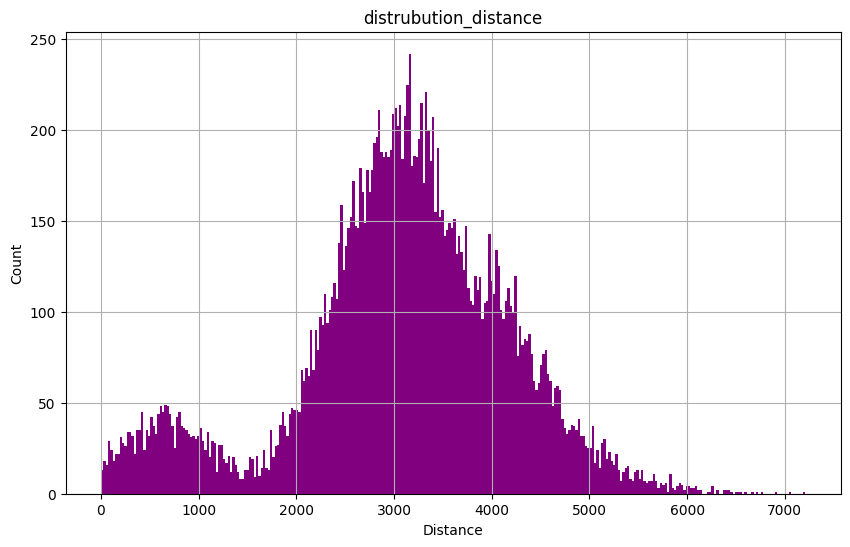

In [62]:
print(color.BOLD + 'Количественная информация' + color.END) # жирный шрифт, чтобы можно было комфортно разлечить блоки
display(rides['distance'].describe())
print(color.BOLD + 'Распределение по расстоянию поездок\n' + color.END)
rides['distance'].hist(bins = 300, color='purple', figsize=(10,6))
plt.title('distrubution_distance')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Минимальное расстояние 0,86м - выглядит несколько странно, это немногим больше, чем длина самого самоката.  
Самые частые пездки примерно от 2,5 км до 3,7км. Вполне стандартные для перемещеня по городу.  
Есть и длинные поездки около 7км, что, впрочем, совсем немного для крупного города.

Посмотрим на диаграмму распределения, чтобы убедиться, что значения меньше 1м это аномалии.

Диаграмма распределения


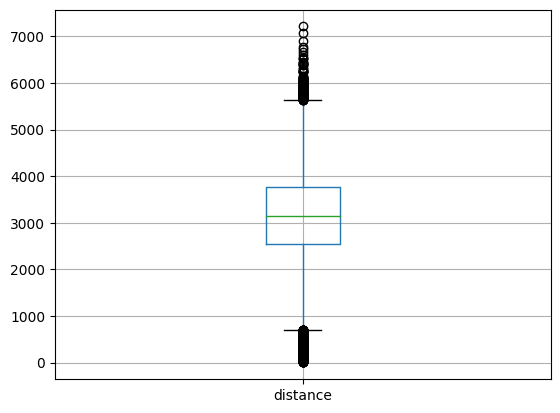

Нижнии пики


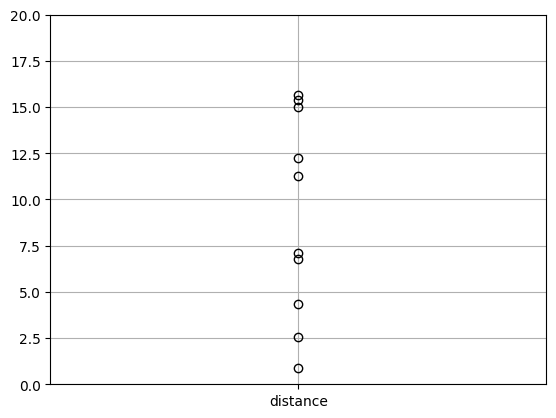

Верхние


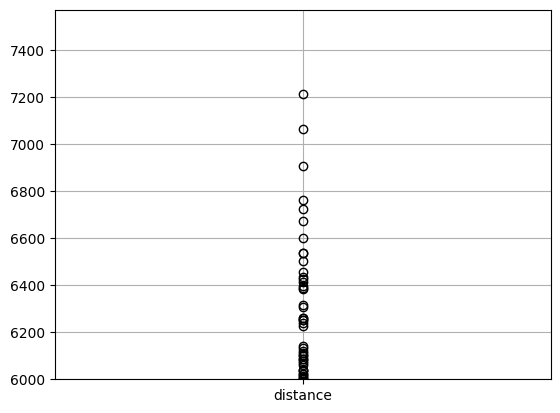

In [63]:
print(color.BOLD + 'Диаграмма распределения' + color.END)
rides.boxplot('distance')
plt.show()
print(color.BOLD + 'Нижнии пики' + color.END)
rides.boxplot('distance')
plt.ylim(0,20)
plt.show()
print(color.BOLD + 'Верхние' + color.END)
rides.boxplot('distance')
plt.ylim(6000)
plt.show()

Можем заметить, несмотря на то, что значения меньше примерно 900м и больше 5,8км отмечены как выбросы, таких поездок достаточно много.  
И даже около 10 поездок на расстояние меньше 17м. Подозреваю, что пользователи брали самокат, но в итоге не ехали.  

Так же, можно увидеть пики на расстоянии более 6,5км, видно, что это очень редкие поездки.

##### Продолжительность поездок

Количественная информация


count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

Распределение по длительности поездок



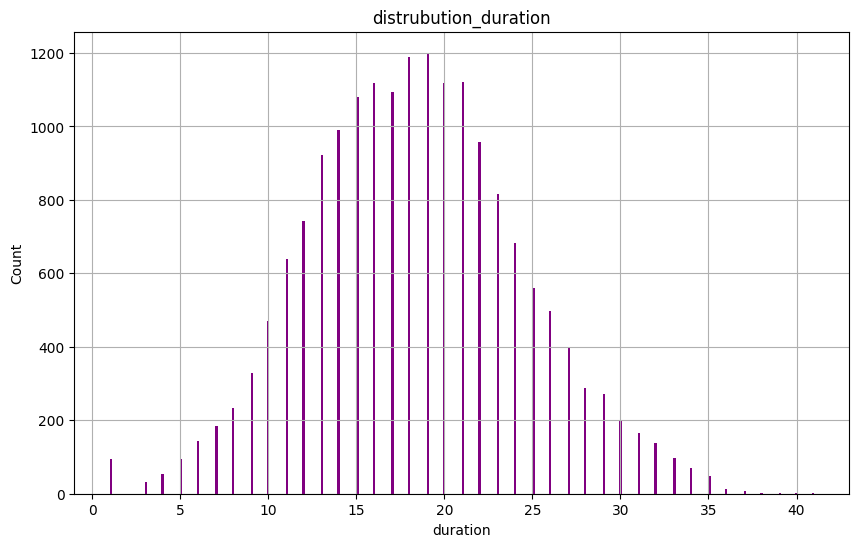

In [64]:
print(color.BOLD + 'Количественная информация' + color.END) # жирный шрифт, чтобы можно было комфортно разлечить блоки
display(rides['duration'].describe())
print(color.BOLD + 'Распределение по длительности поездок\n' + color.END)
rides['duration'].hist( bins = 300, color='purple', figsize=(10,6))
plt.title('distrubution_duration')
plt.xlabel('duration')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Минимальное время - полминуты, так же видим всплеск в районе 1минуты, что вполне коррелирует с минимальными расстояниями.  
Вероятно, пользователи тестировали работу или отказывались от поездки по каким-то еще причинам.  
Основная доля поездок от 13 до 22 минут.  

**Вывод**

1. Сервис представлен в 8 городах (Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи), доли городов распределены доостаточно равномерно - от 11% до 14%, больше всего пользователей из Пятигорска, меньше всего из Москвы.  
2. 46% пользователей пользуются платной подпиской.  
3. Возраст пользователей распределен от 12 до 43 лет. Основная часть - от 22 до 27 лет.При этом, старше 34 пользователей совсем немного.  
4. Самые частые пездки примерно от 2,5 км до 3,7км.  
5. По времени основная доля поездок от 14 до 22 минут. 

## Шаг 4. Объединение данных

Объединим три наши таблицы в один датасет для дальнейшей работы.

In [65]:
data = users.merge(rides,on='user_id').merge(sub,on='subscription_type')
#после объединения мы должны получить 12 колонок и 18068строк. проверим
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27,2021-08-28,8,6,0,199


И разобьем это на два отдельных датафрейма, в зависимости от наличия платной подписки.

In [66]:
free_users = data.query("subscription_type == 'free'")
ultra_users = data.query("subscription_type == 'ultra'")

display(free_users.sample(5)) #посмотриим на пример
ultra_users.sample(5) #посмотриим на пример

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
16247,1406,Вероника,28,Ростов-на-Дону,free,4250.258666,13,2021-07-15,7,8,50,0
14695,1294,Святогор,23,Краснодар,free,3899.331651,21,2021-09-28,9,8,50,0
11685,1077,Наташа,22,Ростов-на-Дону,free,3296.114659,21,2021-11-08,11,8,50,0
7800,793,Амир,22,Пятигорск,free,2598.343733,13,2021-11-16,11,8,50,0
14778,1300,Мария,25,Омск,free,2048.561662,18,2021-08-18,8,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
5730,612,Елена,32,Ростов-на-Дону,ultra,3100.412905,18,2021-06-14,6,6,0,199
146,15,Валерия,24,Тюмень,ultra,4504.150823,27,2021-03-02,3,6,0,199
1939,210,Алексей,23,Омск,ultra,3496.142787,13,2021-07-21,7,6,0,199
4768,513,Иван,28,Пятигорск,ultra,3717.578429,21,2021-04-25,4,6,0,199
3231,349,Федор,25,Сочи,ultra,2618.142941,11,2021-09-08,9,6,0,199


##### Времая и расстояние в разрезе подписки

Длительности поездок в зависимости от подписки(время)


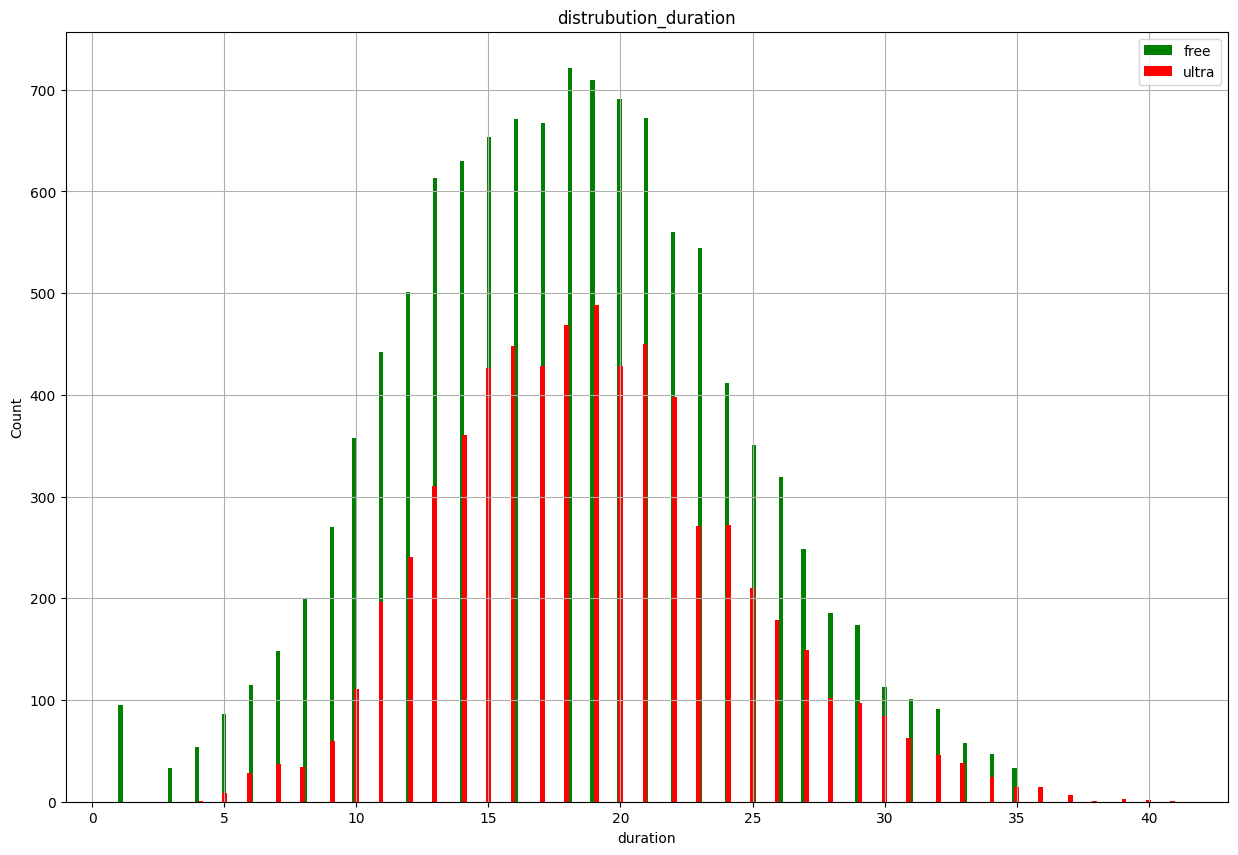

Количественная информация на тарифе free


count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

Количественная информация на тарифе ultra


count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

In [67]:
print(color.BOLD + 'Длительности поездок в зависимости от подписки(время)' + color.END)
free_users['duration'].hist(bins=200, label='free', color='green')
ultra_users['duration'].hist(bins=200, label='ultra', color='red', figsize=(15,10))
plt.title('distrubution_duration')
plt.xlabel('duration')
plt.ylabel('Count')
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
print(color.BOLD + 'Количественная информация на тарифе free' + color.END)
display(free_users['duration'].describe())
print(color.BOLD + 'Количественная информация на тарифе ultra' + color.END)
display(ultra_users['duration'].describe())

В целом, графики очень похожи.  
Средние и медианные значения так же близки, на платной подписке примерно на 1минуту оба значения больше, чем на бесплатном.  
Из странного, что аномально короткие "тестовые" поездки на бесплатном тарифе, при том, что старт там стоит 50р.  

Длительности поездок в зависимости от подписки(расстояние)


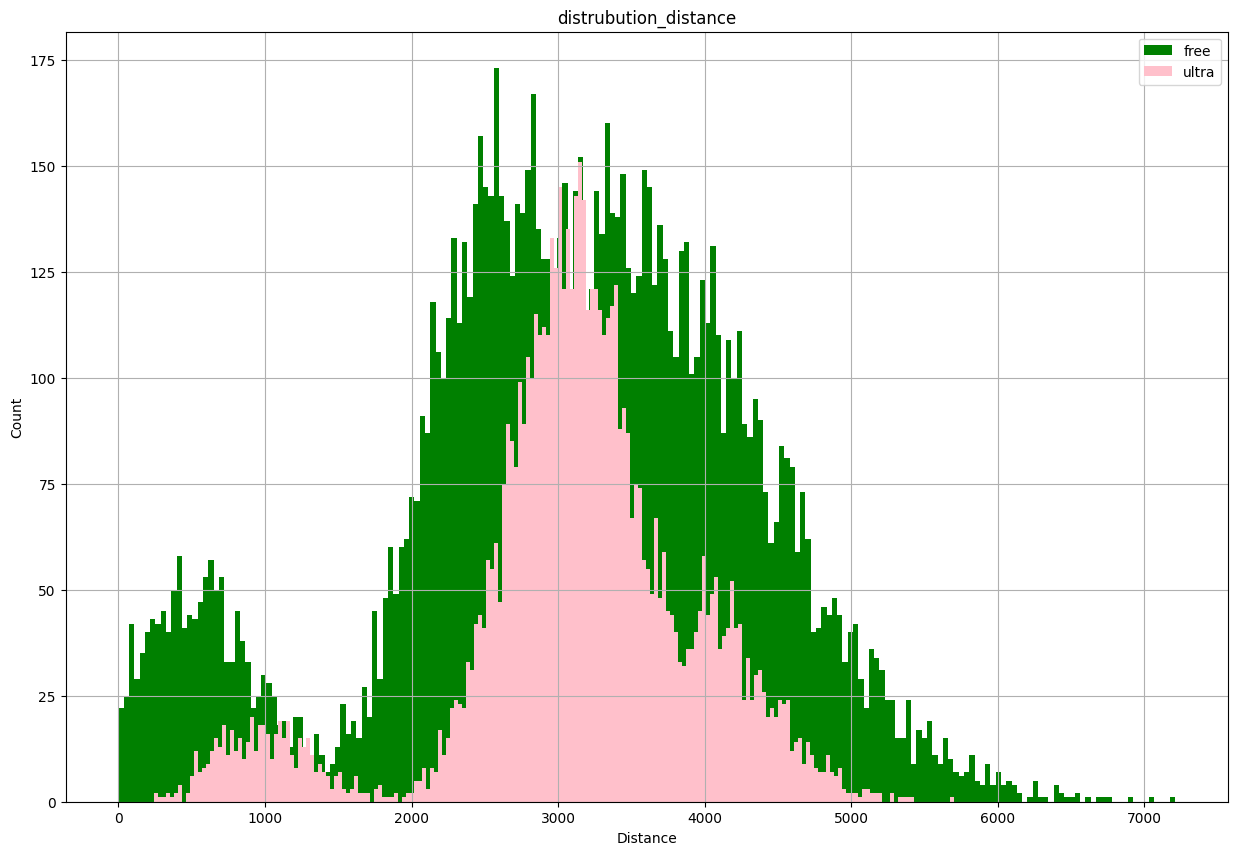

Количественная информация на тарифе free


count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Количественная информация на тарифе ultra


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [68]:
print(color.BOLD + 'Длительности поездок в зависимости от подписки(расстояние)' + color.END)
free_users['distance'].hist(bins=200, label='free', color='green')
ultra_users['distance'].hist(bins=200, label='ultra', color='pink', figsize=(15,10))
plt.title('distrubution_distance')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
print(color.BOLD + 'Количественная информация на тарифе free' + color.END)
display(free_users['distance'].describe())
print(color.BOLD + 'Количественная информация на тарифе ultra' + color.END)
display(ultra_users['distance'].describe())

Здесь картинка та же, что и в распределении времени, значения на разных типах подписки очень близки.  
Из интересного, максимальное время поездок больше на платном тарифе, а расстояние, наоборот, на бесплатном.  
Возможно, т.к. на free тарифе пользователи платят и за старт поездки и за каждую минуту, они стараются экономить и едут быстрее, но средние отличаются слишком мало, поэтому, это лишь допущение.

**Вывод**
 
Наличие или отсутствие платной подписки, на первый взгляд, не слишком влияют на средние показатели расстояния и времени одной поездки. Средние показатели времени на 1мин больше на платном тарифе, Средние расстояния всего на пару сотен метров.

## Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках, найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.  
При этом, оставим в новой таблице данные о подписках, чтобы можно далее легко было подсчитать выручку от каждого пользователя.

In [69]:
agg_data = data.groupby(by=['user_id', 'month'])\
.agg({'distance':'sum', 'user_id':'count', 'duration':'sum', 'subscription_type':'min', 'minute_price':'min', 'start_ride_price':'min', 'subscription_fee':'min'})\
.rename(columns={'user_id': 'count_rides'})
agg_data.head(10)

distance  count_rides  duration subscription_type  \
user_id month                                                          
1       1       7027.511294            2        42             ultra   
        4        754.159807            1         7             ultra   
        8       6723.470560            2        46             ultra   
        10      5809.911100            2        32             ultra   
        11      7003.499363            3        56             ultra   
        12      6751.629942            2        28             ultra   
2       3      10187.723006            3        63             ultra   
        4       6164.381824            2        40             ultra   
        6       3255.338202            1        14             ultra   
        7       6780.722964            2        48             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
        12                6                 0               199  
2       3                 6                 0               199  
        4                 6                 0               199  
        6                 6                 0               199  
        7                 6                 0               199

In [70]:
#для получения суммы выручки с каждого пользователя за месяц, нам нужно:
#стоимость старата * количество поездок (для ultra это будет 0) 
# + количество минут * стоимость одной минуты 
# и + стоимость подписки (для free это будет 0)
agg_data['income'] = ((agg_data['start_ride_price'] * agg_data['count_rides'])\
+ (agg_data['minute_price'] * agg_data['duration'])\
   + agg_data['subscription_fee']).astype('int')
agg_data.head(10)

distance  count_rides  duration subscription_type  \
user_id month                                                          
1       1       7027.511294            2        42             ultra   
        4        754.159807            1         7             ultra   
        8       6723.470560            2        46             ultra   
        10      5809.911100            2        32             ultra   
        11      7003.499363            3        56             ultra   
        12      6751.629942            2        28             ultra   
2       3      10187.723006            3        63             ultra   
        4       6164.381824            2        40             ultra   
        6       3255.338202            1        14             ultra   
        7       6780.722964            2        48             ultra   

               minute_price  start_ride_price  subscription_fee  income  
user_id month                                                            
1       1                 6                 0               199     451  
        4                 6                 0               199     241  
        8                 6                 0               199     475  
        10                6                 0               199     391  
        11                6                 0               199     535  
        12                6                 0               199     367  
2       3                 6                 0               199     577  
        4                 6                 0               199     439  
        6                 6                 0               199     283  
        7                 6                 0               199     487

In [71]:
# разобьем так же на два датасета в зависимости от подписки
agg_free = agg_data.query("subscription_type == 'free'")
agg_ultra = agg_data.query("subscription_type == 'ultra'")

display(agg_free.head())
agg_ultra.head()

distance  count_rides  duration subscription_type  \
user_id month                                                          
700     1       2515.690719            1        15              free   
        2      13446.659764            5        89              free   
        3       3798.334905            1        19              free   
        4       2984.551206            1        16              free   
        6       5927.650988            2        29              free   

               minute_price  start_ride_price  subscription_fee  income  
user_id month                                                            
700     1                 8                50                 0     170  
        2                 8                50                 0     962  
        3                 8                50                 0     202  
        4                 8                50                 0     178  
        6                 8                50                 0     332

distance  count_rides  duration subscription_type  \
user_id month                                                         
1       1      7027.511294            2        42             ultra   
        4       754.159807            1         7             ultra   
        8      6723.470560            2        46             ultra   
        10     5809.911100            2        32             ultra   
        11     7003.499363            3        56             ultra   

               minute_price  start_ride_price  subscription_fee  income  
user_id month                                                            
1       1                 6                 0               199     451  
        4                 6                 0               199     241  
        8                 6                 0               199     475  
        10                6                 0               199     391  
        11                6                 0               199     535

## Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки?  
Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. 

Нам нужно понять, действительно ли среднее время поездок пользователей на платных тарифах выше.  
Для этого мы воспользуемся т-тестом двух независимых выборок.  

Нулевая гипотеза H0 будет звучать так: "Среднее время поездок на платном тарифе = среднему времени на бесплатном",
Н1: "Среднее время поездок на платном тарифе больше, чем среднее время на бесплатном".  

Для проверки, найдем р-значение - верояность случайно получить наблюдаемое или любое другое значение, при условии верности нулевой гипотезы.  
Порог уровня статистической значимости примем за 5%.  
И, т.к. Н1 у нас "больше", тест будет правосторонний.
 

In [72]:
ultra = ultra_users['duration']

free = free_users['duration']


alpha = 0.05
 
results = st.ttest_ind(ultra, free, alternative = 'greater')
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Среднее время поездок для пользователей free:', free_users['duration'].mean().round())
print('Среднее время поездок для пользователей ultra:', ultra_users['duration'].mean().round())

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу
Среднее время поездок для пользователей free: 18.0
Среднее время поездок для пользователей ultra: 19.0


**Мы получили р-значение очень близкое к 0, сильно меньше 5%, значит, нам нужно отвергнуть Н0 в пользу Н1 "Среднее время поездок на платном тарифе больше, чем среднее время на бесплатном".**

##### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?  
Проверим гипотезу и сделайте выводы.

В данном т-тесте мы будем сравнивать среднее выборки с конкретны значением (3130м).  
Н0: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, = 3130м  
Н1 среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, > 3130м.  

Тест будет правосторонним, уровень стат.значимости так же примем за стандартные 5%.

In [73]:
ultra = ultra_users['distance']

optim = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra, 
    optim,
      alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

print('Среднее расстояние поездок для пользователей ultra:', ultra_users['distance'].mean().round())

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу
Среднее расстояние поездок для пользователей ultra: 3115.0


**Вероятность получить случайное значение выше порога стат.значимости, это значит, что мы не можем отвергнуть нулевую гипотезу.**

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Н0 Выручка от пользователей с подпиской и выручка от пользователей без подписки равны  

Н1 Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.  

В тесте будем сравнивать две независимые выборки, тест будет правосторонним и уровень стат значимости стандартный.

In [74]:
ultra = agg_ultra['income']

free = agg_free['income']


alpha = 0.05
 
results = st.ttest_ind(ultra, free, alternative = 'greater')
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Средняя помесячная выручка пользователей с подпиской:', agg_ultra['income'].mean().round())
print('Средняя помесячная выручка пользователей без подписки:', agg_free['income'].mean().round())

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу
Средняя помесячная выручка пользователей с подпиской: 363.0
Средняя помесячная выручка пользователей без подписки: 329.0


**Р-значение вероятности случайного значения стремится к 0, а значит, мы должны отвергнуть Н0 о равенстве средней помесячной выручки пользователей с подпиской и без неё.**

##### Теоритическое рассуждение

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?  

Нам бы подошел т-тест для сравнения двух зависимых (парных) выборок.  
st.ttest_rel(before, after), тест был бы правосторонним.  
Н0 before = after  
Н1 before > after

# Общий вывод

1. Мы ознакомились с данными и провели небольшую предобработку:  

* Мы имеем информацию о 1534 пользователях сервиса GoFast  

* Информация собрана по 8 городам (Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи)  

* Данные представлены за полный 2021г  

* В данных нет пропусков  

* Было небольшое количесто (меньше 2%) дубликатов в таблице о пользователях, мы их удалили  

* Столбец с врменем пездки в минутах округлили вверх и привели к целочисленному типу данных

* Изменили тип данных столбца date таблицы rides на верный (date) и удобный для работы  

* Добавили стобец с Месяцем, извлеченным из даты в таблице о поездках.  

* Объединили таблицы в один датасет для дальнейших исследований.  

* Подсчитали выручку по месяцам от каждого пользователя в зависимости от подписки.


2. Провели исследовательский анализ:  

* Сервис представлен в 8 городах (Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи), доли городов распределены доостаточно равномерно - от 11% до 14%, больше всего пользователей из Пятигорска, меньше всего из Москвы.  

* 46% пользователей пользуются платной подпиской.  

* Возраст пользователей распределен от 12 до 43 лет. Основная часть - от 22 до 27 лет.При этом, старше 34 пользователей совсем немного.  

* Самые частые пездки примерно от 2,5 км до 3,7км.  

* По времени основная доля поездок от 14 до 22 минут.  

* Наличие или отсутствие платной подписки, на первый взгляд, не слишком влияют на средние показатели расстояния и времени одной поездки. Средние показатели времени на 1мин больше на платном тарифе, Средние расстояния всего на пару сотен метров.  

3. Проверили несколько гипотез:  

1) Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.  
  * По результатам т-теста нам нужно отвергнуть гипотезу о равенстве среднего времени поездки в пользу гипотезы "Среднее время поездок на платном тарифе больше, чем среднее время на бесплатном".  
  
2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?  
  * Нам не удалось отвергнуть гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, ровняется 3130м.  
  
3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.  
  * Отвергли гипотезу о равенстве помесячной выручки пользователей с подпиской и без в пользу гипотезы, что выручка от пользователей с подпиской по месяцам выше.  
  

**Итоговый вывод:**  
  На основании проведенных исследований и тестов, можно сказать, что клиенты с платной подпиской для компании более выгодны, чем без неё.